In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
from mca import MCA

import warnings
warnings.simplefilter("ignore")

In [73]:
df_ = pd.read_excel('race_chien.xlsx',index_col=0)
df_.head()

,Taille,Poids,Velocite,Intelligence,Affection,Agressivite,Fonction,Cote
Chien,,,,,,,,
Beauceron,Taille++,Poids+,Veloc++,Intell+,Affec+,Agress+,utilite,2.5
Basset,Taille-,Poids-,Veloc-,Intell-,Affec-,Agress+,chasse,4.5
Berger All,Taille++,Poids+,Veloc++,Intell++,Affec+,Agress+,utilite,3.0
Boxer,Taille+,Poids+,Veloc+,Intell+,Affec+,Agress+,compagnie,2.0
Bull-Dog,Taille-,Poids-,Veloc-,Intell+,Affec+,Agress-,compagnie,4.5


In [74]:
df_.shape

(27, 8)

In [75]:
df = df_.drop(['Fonction','Cote'], axis=1)
df.shape

(27, 6)

In [76]:
I, J = df.shape[0], df.shape[1]
print('Total Individus : {}\nTotal Variables : {}'.format(I, J))

Total Individus : 27
Total Variables : 6


In [77]:
# Statistiques descriptives
df.describe(include=[object])

,Taille,Poids,Velocite,Intelligence,Affection,Agressivite
count,27,27,27,27,27,27
unique,3,3,3,3,2,2
top,Taille++,Poids+,Veloc-,Intell+,Affec+,Agress-
freq,15,14,10,13,14,14


In [78]:
# for i,name in enumerate(df.columns):
#     plt.subplot(2, 3, i+1)
#     df[name].value_counts().plot.bar(figsize=(12,8))
#     plt.title(name)
#     plt.xticks(rotation= 0)
#     plt.tight_layout()
#     plt.suptitle("Diagramme en barres", fontsize=12)
# plt.show()

***Etude du croisement des variables prises 2 à 2 (Test du Khi-deux d'indépendance avec sa pvalue)***

In [79]:
chi2 = pd.DataFrame(np.zeros(shape=(J,J),dtype=float),index=df.columns, columns = df.columns)
pvalue = pd.DataFrame(np.zeros(shape=(J,J),dtype=float),index=df.columns, columns = df.columns)
for i in range(J):
    for j in range(i+1,J):
        tab = pd.crosstab(df.iloc[:,i],df.iloc[:,j])
        chi = stat.chi2_contingency(tab)
        chi2.iloc[i,j] = chi[0]
        pvalue.iloc[i,j]=chi[1]

print('------------- KHI-2 --------------')
chi2.round(3)

------------- KHI-2 --------------


,Taille,Poids,Velocite,Intelligence,Affection,Agressivite
Taille,0.0,25.329,15.891,3.608,13.954,2.051
Poids,0.0,0.000,18.470,1.356,9.476,2.552
Velocite,0.0,0.000,0.000,3.156,2.967,0.575
Intelligence,0.0,0.000,0.000,0.000,3.891,1.157
Affection,0.0,0.000,0.000,0.000,0.000,0.915
Agressivite,0.0,0.000,0.000,0.000,0.000,0.000


In [80]:
print('------------- P-Value --------------')
pvalue.round(3)

------------- P-Value --------------


,Taille,Poids,Velocite,Intelligence,Affection,Agressivite
Taille,0.0,0.0,0.003,0.462,0.001,0.359
Poids,0.0,0.0,0.001,0.852,0.009,0.279
Velocite,0.0,0.0,0.000,0.532,0.227,0.750
Intelligence,0.0,0.0,0.000,0.000,0.143,0.561
Affection,0.0,0.0,0.000,0.000,0.000,0.339
Agressivite,0.0,0.0,0.000,0.000,0.000,0.000


*Les variables **taille, poids et vélocité** sont très liés entre eux. Les variables **intelligence et agressivité sont indépendantes entre elles et des autres variables**. L’ACM va permettre, entre autres, de retrouver ces configurations types en visualisant les races canines et les modalités.*

**Conception du tableau disjonctif complet (TDC)**

Dans le TDC, les lignes sont les individus et les colonnes sont les modalités des variables qualitatives

In [81]:
tdc = pd.get_dummies(df, prefix="",prefix_sep="")
tdc.head(2)

,Taille+,Taille++,Taille-,Poids+,Poids++,Poids-,Veloc+,Veloc++,Veloc-,Intell+,Intell++,Intell-,Affec+,Affec-,Agress+,Agress-
Chien,,,,,,,,,,,,,,,,
Beauceron,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0
Basset,0,0,1,0,0,1,0,0,1,0,0,1,0,1,1,0


L'ACM va étudier la variabilité des individus, c'est-à-dire les ressemblances et différences entre individus <br>
Pour ce faire, l'ACM va extraire les différentes dimensions de variabilités avant de les décrire par les variables (modalités).<br>
<br>
Du point des varaibles, l'ACM va s'interesser aux associations entre modalités

### Mise en Oeuvre de l'ACM

In [82]:
mca = MCA(tdc, ncols=tdc.shape[1], benzecri=False)
# mca.L => Récupéraration des valeurs propres

percent_eigen = np.array([100*x/sum(mca.L) for x in mca.L])

cumpercent = np.cumsum(percent_eigen)
columns = ['Valeur propre','Pourcentage d\'inertie','Pourcentage d\'inertie cumulée']
index = ['Dim.{}'.format(x+1) for x in range(percent_eigen.shape[0])]
eigen_tab = pd.DataFrame(np.transpose([mca.L,percent_eigen,cumpercent]),index=index,columns = columns)
eigen_tab.index.name = 'Dimension'
# Affichage
eigen_tab.round(3)

,Valeur propre,Pourcentage d'inertie,Pourcentage d'inertie cumulée
Dimension,,,
Dim.1,0.482,28.896,28.896
Dim.2,0.385,23.084,51.981
Dim.3,0.211,12.657,64.638
Dim.4,0.158,9.453,74.091
Dim.5,0.150,9.008,83.099
Dim.6,0.123,7.398,90.497
Dim.7,0.081,4.888,95.385
Dim.8,0.046,2.740,98.125
Dim.9,0.024,1.413,99.537


La représentation la plus naturelle de l'ACM est de passer le TDC.

#### ACM via AFC sur le TDC

In [84]:
# ACM via une AFC sur le TDC
from fanalysis.ca import CA
mcaModelCA1 = CA(row_labels=tdc.index.values,col_labels=tdc.columns.values)
mcaModelCA1.fit(tdc.values)
# Valeurs propres
EigenCA1 = pd.DataFrame(mcaModelCA1.eig_.T[:,0],columns = ['lambda'])
EigenCA1.index +=1
EigenCA1.T.round(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
lambda,0.482,0.385,0.211,0.158,0.15,0.123,0.081,0.046,0.024,0.008,0.0,0.0,0.0,0.0,0.0


##### Fonction de visualisation des valeurs propres

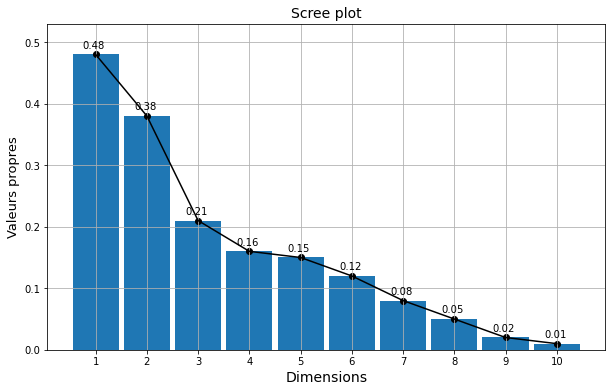

In [86]:
def screeplot(data,figsize=None):
    p = data.shape[0]
    fig,axes = plt.subplots(figsize = figsize); axes.grid()
    axes.set_xlabel('Dimensions',fontsize=14)
    axes.set_title('Scree plot',fontsize=14)
    axes.set_xticks([x for x in range(1,p+1)])
    eigen = data.iloc[:,0].round(2)
    ylim = np.max(eigen)+0.05
    axes.set_ylim(0,ylim)
    axes.bar(np.arange(1,p+1),eigen.values,width=0.9)
    axes.plot(np.arange(1,p+1),eigen.values,c="black")
    axes.set_ylabel('Valeurs propres',fontsize=13)

    for i in range(p):
        axes.scatter(i+1,eigen.values[i],color='black',alpha=1)
        axes.text(i+.75,0.01+eigen.values[i],str(eigen.values[i]), color='black')
        
# Affichage
screeplot(eigen_tab, figsize=(10, 6))

### Nuage des individus

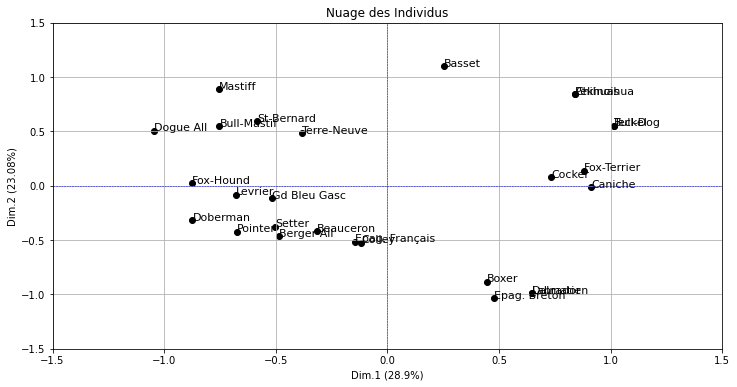

In [95]:
# fs_r => Coordonnées Factorielles
coord_i = pd.DataFrame(mca.fs_r(N=percent_eigen.shape[0]), index=df.index, columns=index)

def mca_plot_i(df, eigen, axe_i, axe_j, title, figsize=None):
    try:
        if axe_i==axe_j:
            raise ValueError('Erreur: axei doit être différent de axej.')
        elif axe_i>axe_j:
            raise ValueError('Erreur: axei doit être inférieur à axej.')
        elif axe_i<0 or axe_j<0:
            msg = 'Erreur: les valeurs des axes doivent être positives ou nulles.'
            raise ValueError(msg)
        else:
            n = df.shape[0]
            percent = np.array([100*x/sum(eigen) for x in eigen])
            dim_i, dim_j = round(percent[axe_i],2), round(percent[axe_j],2)
            fig, axes = plt.subplots(figsize = figsize)
            axes.grid()
            axes.axis([-1.5,1.5,-1.5,1.5])
            axes.set_title(title)
            axes.set_xlabel(f"Dim.{1+axe_i} ({dim_i}%)")
            axes.set_ylabel(f"Dim.{1+axe_j} ({dim_j}%)")
            for i in range(n):
                plt.scatter(df.iloc[i,axe_i], df.iloc[i,axe_j],c = "black", alpha = 1)
                axes.text(df.iloc[i,axe_i], df.iloc[i,axe_j], df.index[i],color = "black", fontsize = 11)
            plt.axhline(0, color='blue',linestyle="--", linewidth=0.5)
            plt.axvline(0, color='blue',linestyle="--", linewidth=0.5)
            plt.show()
    except ValueError as e:
        print(e)
        
mca_plot_i(df=coord_i, eigen=mca.L, axe_i=0, axe_j=1, title='Nuage des Individus', figsize=(12, 6))

### Nuage des Modalités

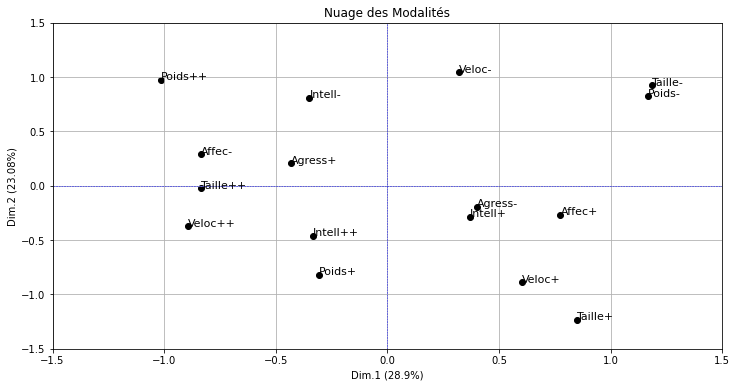

In [101]:
coord_j = pd.DataFrame(mca.fs_c(N=percent_eigen.shape[0]), index=tdc.columns, columns=index)
mca_plot_i(df=coord_j, eigen=mca.L, axe_i=0, axe_j=1, title='Nuage des Modalités', figsize=(12, 6))

### Représentation simultanée

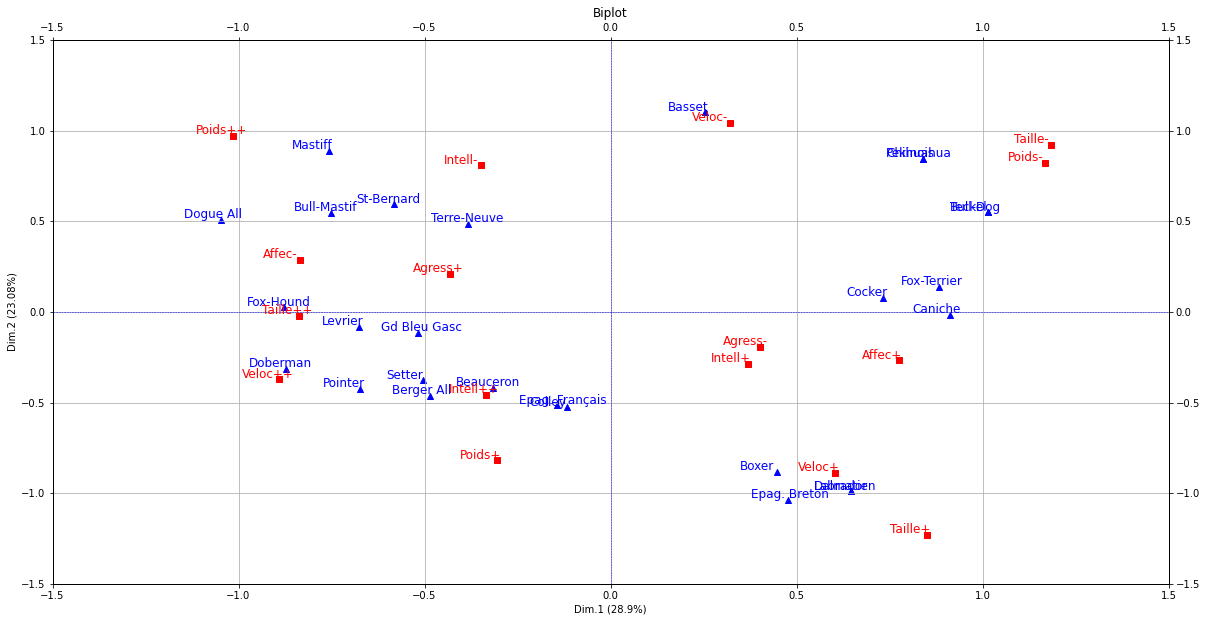

In [103]:
def biplot(df1, df2, eigen, axe_i, axe_j, title, figsize=None):
    try:
        if axe_i==axe_j:
            raise ValueError('Erreur: axei doit être différent de axej.')
        elif axe_i>axe_j:
            raise ValueError('Erreur: axei doit être inférieur à axej.')
        elif axe_i<0 or axe_j<0:
            msg = 'Erreur: les valeurs des axes doivent être positives ou nulles.'
            raise ValueError(msg)
        else:
            n, p = df1.shape[0], df2.shape[0]
            percent = np.array([100*x/sum(eigen) for x in eigen])
            dim_i, dim_j = round(percent[axe_i],2), round(percent[axe_j],2)
            
            # Biplot
            fig = plt.figure(figsize=figsize)
            axes1 = fig.add_subplot(111)
            axes2 = axes1.twiny()
            axes2 = axes2.twinx()
            axes1.grid()
            axes2.axis([-1.5,1.5,-1.5,1.5])
            axes1.axis([-1.5,1.5,-1.5,1.5])
            axes1.set_title(title)
            axes1.set_xlabel(f"Dim.{1+axe_i} ({dim_i}%)")
            axes1.set_ylabel(f"Dim.{1+axe_j} ({dim_j}%)")
            
            # Affichage des individus
            for i in range(n):
                axes1.scatter(df1.iloc[i,0], df1.iloc[i,1], c = "blue",alpha = 1,marker="^")
                axes1.text(df1.iloc[i,0]-0.10,df1.iloc[i,1]+0.01, df1.index[i],color = "blue", fontsize=12)
                
            # Affichage des modalités
            for k in range(p):
                axes2.scatter(df2.iloc[k,0], df2.iloc[k,1], color='red', alpha=1, marker="s")
                axes2.text(df2.iloc[k,0]-0.10, df2.iloc[k,1]+0.01, df2.index[k], color = "red", fontsize=12)
            plt.axhline(0, color='blue',linestyle="--", linewidth=0.5)
            plt.axvline(0, color='blue',linestyle="--", linewidth=0.5)
            plt.show()
    except ValueError as e:
        print(e)
        
biplot(df1=coord_i, df2=coord_j, eigen=mca.L, axe_i=0, axe_j=1, title='Biplot', figsize=(20, 10))

***L'axe 1 oppose les chiens de petites tailles et affectueux au chien de grandes tailles, rapides et aggressifs.<br>L’axe 2 oppose les chiens de taille moyenne, très intelligents à des chiens très lents et peu intelligents.***